This notebook duplicates the function of the ImageBlur example, but adds as many "robust computing" features as we can. 

Note: some of these additions will save us from problems, others just make it easier to see where they come from.

Important Note: where we say something is required in this Notebook, we are just demonstrating - nothing here needs any particular numpy version for example, and as of writing, there is no version 2 yet.

In [3]:
import numpy as np
from PIL import Image

In [4]:
#A flag telling us whether to plot the images
do_plots = True
try:
    import matplotlib.pyplot as plt
except Exception as e:
    #If matplotlib not availble, we can just not plot the images
    print("Matplotlib could not be imported, error message: "+str(e))
    print("No images will be shown")
    do_plots = False

Check that the library versions are recent enough and that any optional features we might use are present

In [5]:
# Needs numpy version '2' or '1.12'
npvers = np.__version__.split('.')
assert(int(npvers[0]) > 1 or int(npvers[0])==1 and int(npvers[1]) > 12)

In [6]:
#One cell per check because execution will cease 
#at the first assertion failure and we'd rather see all the errors

# This is a silly check, but the pattern is useful
assert(Image.open)

Rather than run the code steps as we go, we're first going to define functions for all the parts, and then run the "pipeline" at the very end. We document the functions where we write them, and try to give descriptive names. We also try to make our functions robust against errors. 

Note that now we don't have "CHANGE this line" throughout our notebook - all the inputs are passed to the functions, and we only make changes in the block at the end

In [7]:
def load_image(filename):
    """Open an image file and convert into image data we can process
    Inputs:
    filename - full file path to image
    Returns : the image. Return will be None if image can't be opened or understood
    """
    try:
        img = Image.open(filename).convert('L')
    except Exception as e:
        # We print the exception as well as our own message
        #This is important - something unexpected happened, so why would we
        # assume we know what it was?
        print("Image file not present or could not be opened: "+str(e))
        # return because we can't do anything useful now
        return

    try:
        # We'll work with a resized version of this image
        # First check image is square and give Warning if not!
        # I will allow a tiny bit of un-squareness, at most 1%
        dims = img.size
        if abs(dims[0]-dims[1])/dims[0] > 0.01:
            print("WARNING: Your image is not square. It will be deformed!")
        #Continue anyway because this is not a blocking problem
        
        dim = 2000
        img_resized = img.resize((dim,dim))
    except:
        # Now if anything happens, we'll at least know which step went wrong
        print("Error resizing image")
        # We might try to go on anyway with the original image although
        # beware that this might not be a sensible thing to do
        img_resized = img

    try:
        # ... and convert it into a numpy array of floats
        img_data = np.asarray(img_resized,dtype=float)
    except Exception as e:
        print("Error converting data: "+str(e))

    return img_data
        

In [8]:
def gaussian_blur_with_fft(image, width):
    """ Applies a simple blur by convolving the image with a Gaussian. 
    Convolution is most-easily done by converting to Fourier space and multiplying,
    then converting back into real space. 
    Inputs:
    image - the image (expects np array of float type)
    width - the width (amount) of blur (higher is more)
    Returns: the blurred image
    """
    
    #Check the inputs are OK
    
    #Because image should be an array, we can't just assert(image)
    assert(image is not None)
    # Width should be strictly +ve
    assert(width > 0)
    
    dim = len(image)
    # None of this part should be able to fail unless numpy is missing etc
    # So we can't say much useful if there is any error so use a single try/except block
    try:
        # Define a Gaussian in 1D on a grid with the same number of points as the image
        domain = np.linspace(-5,5,dim)
        gauss = np.exp(-0.5*domain**2/(width*width)) 

        # Roll this around the 1D boundary so that the Gaussian is centered on grid 0,0
        shift = int(dim/2)
        gauss = np.roll(gauss,shift)

        # Turn into a 2D Gaussian
        gauss2D = gauss[:,np.newaxis] * gauss[np.newaxis,:]
    except Exception as e:
        print("Problem creating Gaussian kernel for blur "+str(e))
        #Return the unblurred image. This might be sensible, this might
        # be a TERRIBLE THING TO DO - beware of silent failing!!!
        return image
        
    try:
        # Fourier transform the image and the Gaussian using standard numpy functions
        img_fft   = np.fft.fft2(image)
        gauss_fft = np.fft.fft2(gauss2D)
    except Exception as e:
        print("Problem performing FFTs: "+str(e))
        return image
        
    # Multiplication in Fourier space
    img_conv = img_fft*gauss_fft
    try:
        # Transform the result back into real space using the inverse transform
        img_ifft = np.fft.ifft2(img_conv)
    except Exception as e:
        print("Problem with inverse transform "+str(e))
        return image
        
    return img_ifft.real

This last section is the actual code. 

As in the other notebook I am using an image of penguin (Photo by Pixabay from Pexels) but any jpg will work.

Note that the "meat" of the code is now a LOT more compact, and it becomes a lot clearer where we should make changes and things.

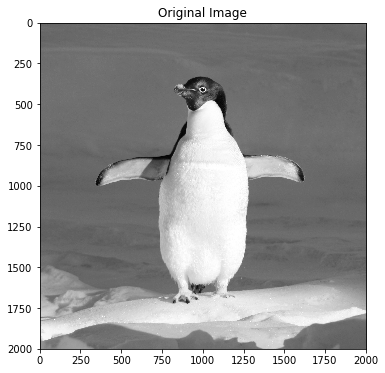

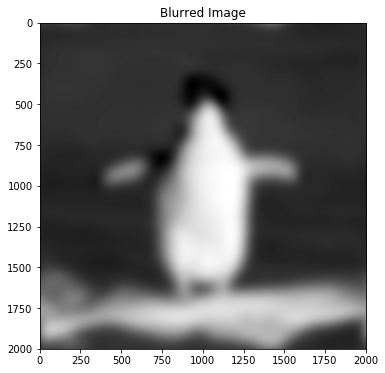

In [9]:
# Load the image
img_data = load_image('penguin.jpg')

if do_plots:
    # Show the image
    plt.figure(figsize = [6, 6])
    plt.imshow(img_data, cmap='gray')
    plt.title("Original Image")

#Do the blur
img_blurred = gaussian_blur_with_fft(img_data, 0.2)

if do_plots:
    # Display the result of blurring the picture
    plt.figure(figsize = [6, 6])
    plt.imshow(img_blurred, cmap='gray')

    # NOTE: the semi-colon ';' stops the result of this line being printed
    plt.title("Blurred Image");

The cell below fails, to show how the assertions work

In [10]:
img_blurred = gaussian_blur_with_fft(img_data, -0.2)

AssertionError: 